<a href="https://colab.research.google.com/github/Shir-Nitzan/Deep-learning-for-computer-vision/blob/main/HW3_315396283.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
       cat       bird       ship      horse


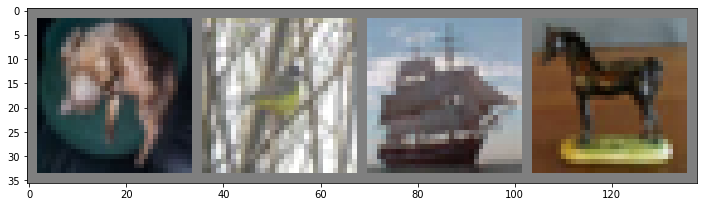

In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value. 

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class. 
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs. 
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.batch_norm1 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(in_features=64 * 8* 8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.logSoftmax = nn.LogSoftmax(dim=1)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 64 * 8* 8)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.logSoftmax(x)
        return x
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

net = Net()
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   # 
#############################################################################
lr=0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = net.to(device)





criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [ ]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        # 
#############################################################################
def calc_accuracy():
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  model.train()
  return correct * 100 / total




train_iterator = iter(trainloader)
num_epochs = 10
totalTrainLoss = 0
totalValLoss = 0
size_train = len(trainloader.dataset)



net.train_losses = []
net.train_accuracies = []
net.test_accuracies = []
running_loss, running_corrects = 0, 0
for epoch in range(0, num_epochs):
  model.train()
  running_loss, running_corrects = 0, 0
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model.forward(inputs)
    
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()



    running_loss += loss.item()
    running_corrects += (outputs.argmax(1) == labels).type(torch.float).sum().item()

  epoch_loss = running_loss / size_train
  epoch_acc = 100 * running_corrects / size_train
  net.train_losses.append(epoch_loss)
  net.train_accuracies.append(epoch_acc)

  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(epoch_loss, epoch_acc))

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Train loss: 0.024257, Train accuracy: 44.1000
Train loss: 0.019825, Train accuracy: 54.9980
Train loss: 0.018367, Train accuracy: 58.4980
Train loss: 0.017515, Train accuracy: 60.3800
Train loss: 0.016769, Train accuracy: 62.2580
Train loss: 0.016100, Train accuracy: 63.9200
Train loss: 0.015775, Train accuracy: 64.4500
Train loss: 0.015229, Train accuracy: 65.7580
Train loss: 0.015010, Train accuracy: 66.3160
Train loss: 0.014639, Train accuracy: 67.0640


## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)** 

Test accuracy: 0.7234


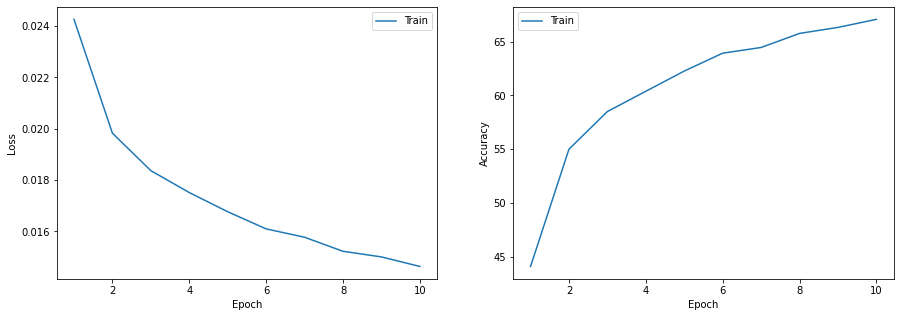

Model accuracy on 10000 test images: 72.34%


In [ ]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################
outputs = None
labels = None
def calc_confusion_matrix(loader):
  net.eval()
  confusion_matrix = np.zeros([10,10], float)
  total_for_label = np.zeros(10)
  correct = 0
  total = 0
  with torch.no_grad():
      for data in loader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          for i in range(len(predicted)):
            p = predicted[i]
            l = labels[i]
            confusion_matrix[l,p]+=1
            total_for_label[l] += 1 
      for i in range(10):
        if total_for_label[i] != 0:
          confusion_matrix[i] /= total_for_label[i]

  net.train()
  return (correct/total, confusion_matrix)

acc, confusion_matrix = calc_confusion_matrix(testloader)
print('Test accuracy:', acc)


def vizualize_loss_and_accuracy():

  num_epochs = 10
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


  ax1.plot(range(1, num_epochs+1), net.train_losses, label='Train')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()

  # Plot accuracy vs epoch
  ax2.plot(range(1, num_epochs+1), net.train_accuracies, label='Train')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  # Show plot
  plt.show()


def evaluation():

      model_accuracy = calc_accuracy()
      vizualize_loss_and_accuracy()
      return model_accuracy



model_accuracy = evaluation()
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy ))

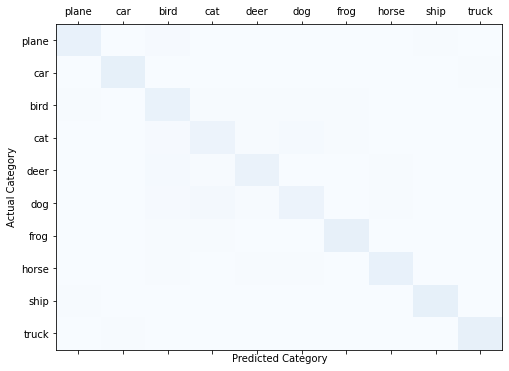

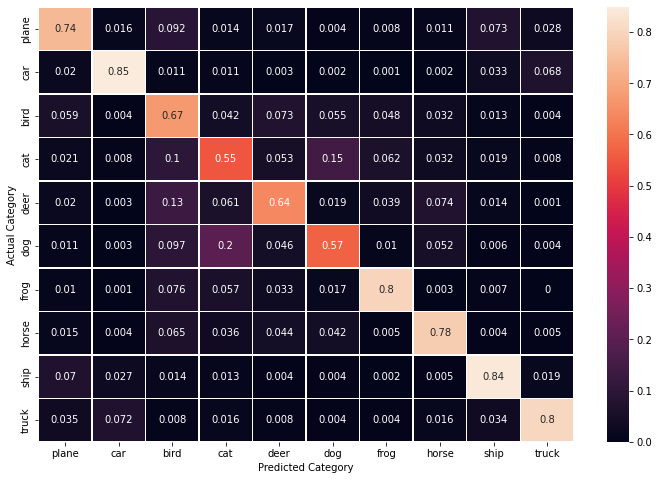

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6))


ax.matshow( [[element * 100 for element in row] for row in confusion_matrix], aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()



import seaborn as sns
sns.heatmap(confusion_matrix, linewidth=0.5, annot=True, 
            xticklabels=classes, yticklabels=classes )
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.show()

##**Question:** 
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:**  I started with a minimal model and then I started to add more and more convolutions, regulization and added more channels and saw an improvement in accuracy (I also printed the training acc in each epoc that helped me).
first I started with only 2 convolutions, and 2 fully connected layers, it gave me relatively low accuracy).
So I decided to added another convolutions, of kernel sized 3, so that the computations wouldn't be very long.
This did a good job and the accuracy jumped. I also tried to increase the number of features (channels) that also helped to improve accuracy.
There also was dis-improvment from deleting one fully connected layer at the end. So I stayed with 2 fully connected layers at the end, so the network will have all the info it needs to to do the classification.
Drop uot had littel helped, before the fully layers, (added it when my accuracy was relatively high)   
Another improvement was to use two 3X3 Convolution instead of one 5x5, it made the same receptive field while reducing the number of parameters, making it faster and adding another non-linearity by ReLU gave better results.
I also tried different lr - lr=0.001, 0.01 , 0.1, the best result was lr=0.001. I guess the step in 0.01 was bigger than we needed because the accuracy wend down in this case. 

##**Question:** 
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:** Cat accuracy is the worst. And cat and dogs are often confused by the model, that make sense because they are very similay and have similay features.
Also the model can confuse a bit between plane and bird, and between deer and horse, that make sense also. 


total accuracy can't see the Unbalanced classification problem: when the data have a bias toward some class, so the model can just predict such class and had high accuracy. But the model is probably not good.

We can learn a lot about the model from confusion_matrix (and learn what can be improved) and we can't  account only from just total accuracy.

# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images. 

In [ ]:
# I had to mount it to drive so it would word. otherwise my env didn't work. the kernel died every time I did plt.imshow
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/data')



import torchvision.transforms as transforms
from dataloader import *

# from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [ ]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "/content/drive/MyDrive/data/animals"

# root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

<Figure size 864x576 with 0 Axes>

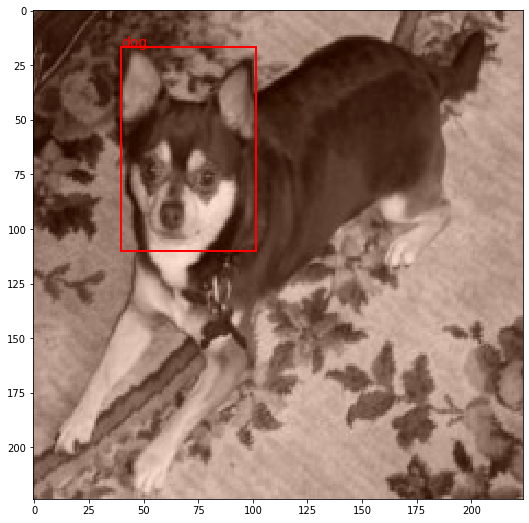

In [ ]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only      #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # This function has no return value.                                        #
        #############################################################################
        model_res = models.resnet18(pretrained=True)
        for param in resnet18.parameters():
          param.requires_grad = False

        features_amount = model_res.fc.in_features
        self.features_amount = features_amount
        model_res.fc = nn.Linear(features_amount, num_classes)
        self.extracted_features = nn.Sequential(*list(model_res.children())[:-1])
        self.class_model =  nn.Sequential( nn.Linear(features_amount, num_classes), nn.Softmax()) 
        self.bbox_model = nn.Sequential(  nn.Linear(features_amount, 256), nn.BatchNorm1d(256),nn.ReLU(), nn.Linear(256, 4))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################
        features = self.extracted_features(images)
        features = torch.flatten(features, 1)

        predictions = self.class_model(features)
        bounding_box = self.bbox_model(features)
        return predictions, bounding_box
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

## Explanation about my results:
The resnet18 layers gave us relatively good enough features, so I didn't had to add a-lot of layers, So for classifier I used one fully connected and softmax at the end: it is enough, it is not hard problem, resnet18 was pretrained for classification.

For the bbox however I first used two FC layers separated by ReLU (it gave me very good results but took more than 15 min so I left with only one fc layey). bbox prediction is harder, and it's an different task from cllasification and need more context, so adding additional FC is good for enrich the context. At the end I am My cri

For bbox optimizer I considered MSE because it is often used for regression tasks where the goal is to predict a continuous numerical value (and not classification) for the cllasification I used Adam, it less made me tune the hyper parameters, and converged good enough, and suted for this task.

In [ ]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    losses_h = {'train':[],'val':[]}
    accuracies_h = {'train':[],'val':[]}
    iou_h = {'train':[],'val':[]}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score
            
            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################
                # pass
                image_i, label, box = sample['image'].to(device), sample['label'].to(device), sample['bbox'].to(device)
                if (phase == 'train'):
                  optimizer.zero_grad()

              
                with torch.set_grad_enabled(phase == 'train'):
                    predicted_class, predicted_box = model(image_i)
                    loss_class = criterion_cls(predicted_class, label)
                    loss_bbox = criterion_bbox(predicted_box, box)
                    loss = loss_class+0.5*loss_bbox

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() 
                running_corrects += sum(label==torch.max(predicted_class.data, 1)[1])
                iou += sum([bb_intersection_over_union(predicted_box[i],box[i]) for i in range(len(predicted_box))])

                

                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            iou = iou.item() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            losses_h[phase] += [epoch_loss]
            accuracies_h[phase] += [epoch_acc]
            iou_h[phase] += [iou]

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses_h, accuracies_h, iou_h

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [ ]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
# pass
lr=0.0001
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


criterion_bbox = nn.MSELoss()
criterion_cls = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr)
# Define the loss function
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
best_model, losses_h, accuracies_h, iou_h = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 1/10
----------


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train Loss: 0.0171  |  Acc: 0.9167  |  IOU: 0.2844
val Loss: 0.0134  |  Acc: 0.9937  |  IOU: 0.3056
Epoch 2/10
----------
train Loss: 0.0116  |  Acc: 0.9969  |  IOU: 0.4963
val Loss: 0.0114  |  Acc: 0.9873  |  IOU: 0.5463
Epoch 3/10
----------
train Loss: 0.0105  |  Acc: 0.9984  |  IOU: 0.6667
val Loss: 0.0112  |  Acc: 1.0000  |  IOU: 0.5832
Epoch 4/10
----------
train Loss: 0.0101  |  Acc: 1.0000  |  IOU: 0.7648
val Loss: 0.0109  |  Acc: 0.9937  |  IOU: 0.6545
Epoch 5/10
----------
train Loss: 0.0100  |  Acc: 1.0000  |  IOU: 0.8049
val Loss: 0.0108  |  Acc: 0.9937  |  IOU: 0.6915
Epoch 6/10
----------
train Loss: 0.0100  |  Acc: 1.0000  |  IOU: 0.8162
val Loss: 0.0107  |  Acc: 0.9937  |  IOU: 0.6937
Epoch 7/10
----------
train Loss: 0.0100  |  Acc: 1.0000  |  IOU: 0.8185
val Loss: 0.0107  |  Acc: 0.9873  |  IOU: 0.6908
Epoch 8/10
----------
train Loss: 0.0100  |  Acc: 1.0000  |  IOU: 0.8281
val Loss: 0.0106  |  Acc: 0.9937  |  IOU: 0.7014
Epoch 9/10
----------
train Loss: 0.0100  |  A

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

<Figure size 864x576 with 0 Axes>

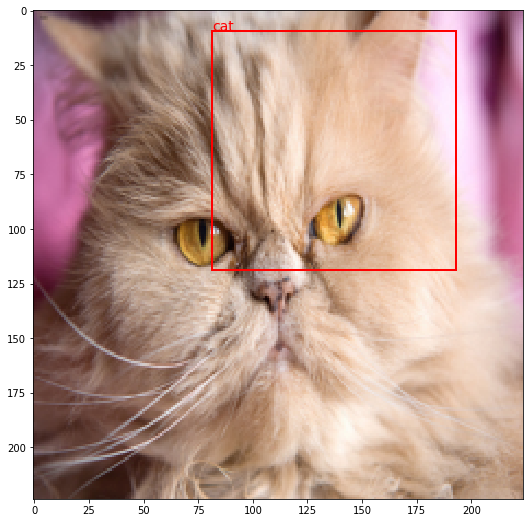

In [ ]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

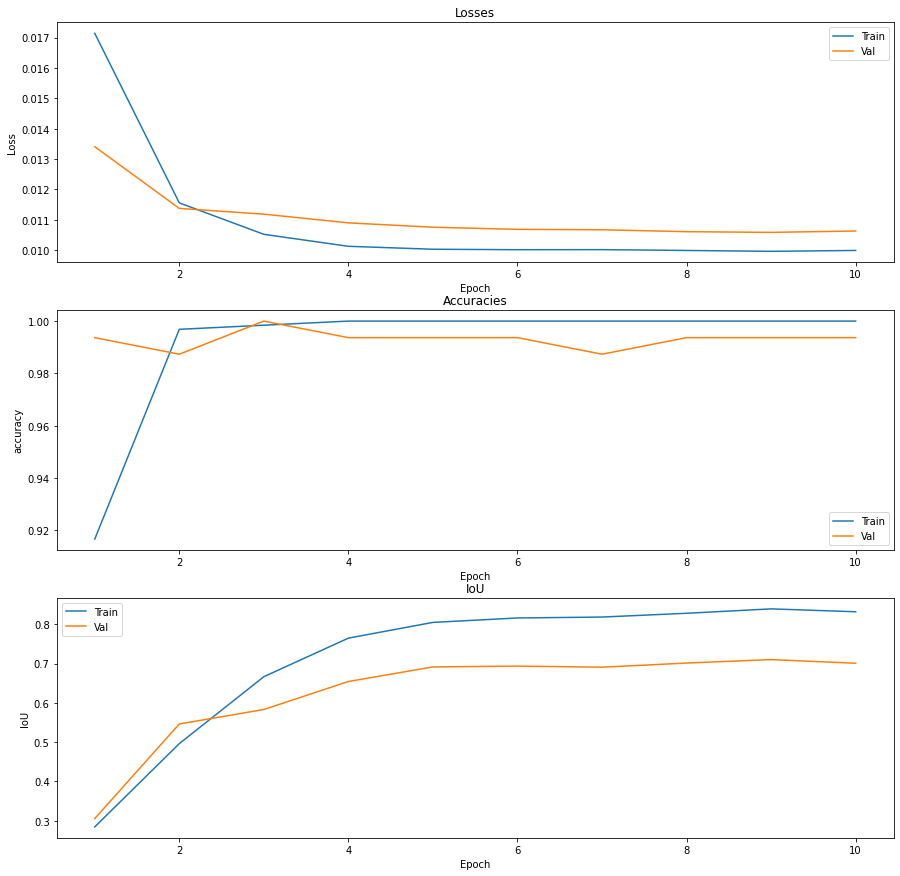

In [ ]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)

epochs = range(10)



def vizualize_loss_and_accuracy_and_iou():

  ax =  plt.subplot(311)
  # print(accuracies_h, 'accuracies_h')
  ax.plot(range(1, 10+1), losses_h['train'], label='Train')
  ax.plot(range(1, 10+1), losses_h['val'], label='Val')

  ax.set_title('Losses')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  ax.legend()

  new_acc_train = []
  for i,value in enumerate(accuracies_h['train']):
    if isinstance(value, torch.Tensor):
      value_np = value.cpu().data.numpy()
      new_acc_train.append(value_np)
    else:
      new_acc_train.append(value)


  new_val_train = []
  for i,value in enumerate(accuracies_h['val']):
    if isinstance(value, torch.Tensor):
      value_np = value.cpu().data.numpy()
      new_val_train.append(value_np)
    else:
      new_val_train.append(value)


      

  ax1 =  plt.subplot(312)
  ax1.plot(range(1, 10+1), new_acc_train, label='Train')
  ax1.plot(range(1, 10+1), new_val_train, label='Val')

  ax1.set_title('Accuracies')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('accuracy')
  ax1.legend()


  ax2 =  plt.subplot(313)
  ax2.plot(range(1, 10+1), iou_h['train'], label='Train')
  ax2.plot(range(1, 10+1), iou_h['val'], label='Val')

  ax2.set_title('IoU')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('IoU')
  ax2.legend()





vizualize_loss_and_accuracy_and_iou()

